<a href="https://colab.research.google.com/github/canmike/lulc_semantic_segmentation/blob/main/segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchmetrics
!pip install -U segmentation-models-pytorch
!pip install lightning
!pip install -U albumentations

# 1. Downloading .py Files

In [ ]:
import requests
from pathlib import Path

def download_py(file_name:str, path:str=None):
  if path == None:
    path = "https://raw.githubusercontent.com/canmike/lulc_semantic_segmentation/main/" + file_name

  if Path(file_name).is_file():
    print(f"{file_name} already exists, skipping download")
  else:
    # Note: you need the "raw" GitHub URL for this to work
    request = requests.get(path)
    with open(file_name, "wb") as f:
      f.write(request.content)
    print(f"Downloaded {file_name}.")

In [ ]:
download_py("utils.py")
download_py("visualization.py")
download_py("training.py")
download_py("dataset.py")

Downloaded utils.py.
Downloaded visualization.py.
Downloaded training.py.
Downloaded dataset.py.


# 2. Getting Data Ready

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import zipfile
from pathlib import Path
import os
data_path = Path("/content/drive/MyDrive/WHISPERS/data")
new_path = Path("data")
with zipfile.ZipFile(data_path / "C2Seg_AB_splitted.zip", "r") as zip_ref:
    print("Unzipping C2Seg_AB data...")
    zip_ref.extractall(new_path)

Unzipping C2Seg_AB data...


In [ ]:
data_path = Path("/content/drive/MyDrive/WHISPERS/data")
new_path = Path("data")
with zipfile.ZipFile(data_path / "C2Seg_BW_splitted.zip", "r") as zip_ref:
    print("Unzipping C2Seg_BW data...")
    zip_ref.extractall(new_path)

Unzipping C2Seg_BW data...


# 3. Setting Models

In [ ]:
import torch
import torchvision
import torch.nn as nn
from torch import optim
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal

In [ ]:
use_msi=True # 4
use_sar=True # 2
use_hsi=False # ...
reduce_hsi=False
reduce_bands=20

in_channels = 0
if use_msi:
  in_channels += 4
if use_sar:
  in_channels += 2
if use_hsi:
  if reduce_hsi:
    in_channels += reduce_bands
  else:
    in_channels += 248

in_channels

6

## 3.1 Setting up device agnostic code

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# 4. Defining color-labels

In [ ]:
import numpy as np
label_map = np.array([
      (0, 0, 0),          # 0 - Background (Black)
      (0, 0, 255),        # 1 - Surface water (Blue)
      (135, 206, 250),    # 2 - Street (Light Sky Blue)
      (255, 255, 0),      # 3 - Urban Fabric (Yellow)
      (128, 0, 0),        # 4 - Industrial, commercial and transport (Maroon)
      (139, 37, 0),       # 5 - Mine, dump, and construction sites (Reddish Brown)
      (0, 128, 0),        # 6 - Artificial, vegetated areas (Green)
      (255, 165, 0),      # 7 - Arable Land (Orange)
      (0, 255, 0),        # 8 - Permanent Crops (Lime Green)
      (154, 205, 50),     # 9 - Pastures (Yellow Green)
      (34, 139, 34),      # 10 - Forests (Forest Green)
      (139, 69, 19),      # 11 - Shrub (Saddle Brown)
      (245, 245, 220),    # 12 - Open spaces with no vegetation (Beige)
      (0, 255, 255),      # 13 - Inland wetlands (Cyan)
  ])


labels = [
    "Background", "Surface water", "Street", "Urban Fabric", "Industrial, commercial and transport",
    "Mine, dump, and construction sites", "Artificial, vegetated areas", "Arable Land",
    "Permanent Crops", "Pastures", "Forests", "Shrub", "Open spaces with no vegetation", "Inland wetlands"
]

# 5. Training Model

## 5.1 Creating DataLoaders

In [ ]:
import albumentations as albu

In [ ]:
def get_data_count(filepath="data/C2Seg_AB_splitted/train/msi"):
  files = os.listdir(filepath)
  # files = sorted(files, key=lambda x: int(x.split(".")[0]))
  return len(files)

In [ ]:
data_count_train_bw = get_data_count(filepath="data/C2Seg_BW_splitted/train/msi")
data_count_val_bw = get_data_count(filepath="data/C2Seg_BW_splitted/val/msi")
data_count_test_bw = get_data_count(filepath="data/C2Seg_BW_splitted/test/msi")

data_count_train_ab = get_data_count(filepath="data/C2Seg_AB_splitted/train/msi")
data_count_val_ab = get_data_count(filepath="data/C2Seg_AB_splitted/val/msi")
data_count_test_ab = get_data_count(filepath="data/C2Seg_AB_splitted/test/msi")

In [ ]:
data_count_train_bw, data_count_val_bw, data_count_test_bw

(19992, 4284, 4284)

In [ ]:
data_count_train_bw + data_count_val_bw + data_count_test_bw

28560

In [ ]:
def transform_normalize(X, y):
  mean = X.mean()
  std = X.std()
  X = (X - mean + 1e-12) / (std + 1e-12)
  return X, y

In [ ]:
def training_transform(img, mask):
  img = img.squeeze().permute(1, 2, 0).numpy()
  augmentation = albu.Compose([
        albu.HorizontalFlip(p=0.5),
        albu.VerticalFlip(p=0.5),
        #albu.Rotate(limit=30, p=0.5),
        #albu.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=0, p=0.5)
    ])
  result = augmentation(image=img, mask=mask)
  return torch.from_numpy(result["image"]).permute(2,0,1), result["mask"]

In [ ]:
batch_size=32

In [ ]:
from dataset import SegmentationDataSet
from torch.utils import data
training_dataset_ab = SegmentationDataSet(indexes=list(range(data_count_train_ab)),
                                       file_path= "/content/data/C2Seg_AB_splitted/train",
                                       #transform=transform_normalize,
                                       transform=training_transform,
                                       use_sar=use_sar,
                                       use_msi=use_msi,
                                       use_hsi=use_hsi,
                                       reduce_hsi=reduce_hsi,
                                       reduce_bands=reduce_bands)

training_dataloader_ab = data.DataLoader(dataset=training_dataset_ab,
                                      batch_size=batch_size,
                                      shuffle=True)
x, y = next(iter(training_dataloader_ab))

print(f'x = shape: {x.shape}; type: {x.dtype}')
print(f'x = min: {x.min()}; max: {x.max()}')
print(f'y = shape: {y.shape}; class: {y.unique()}; type: {y.dtype}')

x = shape: torch.Size([32, 6, 128, 128]); type: torch.float32
x = min: -31.539642333984375; max: 7302.0
y = shape: torch.Size([32, 128, 128]); class: tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.]); type: torch.float32


In [ ]:
val_dataset_ab = SegmentationDataSet(indexes=list(range(data_count_val_ab)),
                                       file_path= "/content/data/C2Seg_AB_splitted/val",
                                       #transform=transform_normalize,
                                       use_sar=use_sar,
                                       use_msi=use_msi,
                                       use_hsi=use_hsi,
                                       reduce_hsi=reduce_hsi,
                                       reduce_bands=reduce_bands)

val_dataloader_ab = data.DataLoader(dataset=val_dataset_ab,
                                      batch_size=batch_size,
                                      shuffle=True)
x, y = next(iter(val_dataloader_ab))

print(f'x = shape: {x.shape}; type: {x.dtype}')
print(f'x = min: {x.min()}; max: {x.max()}')
print(f'y = shape: {y.shape}; class: {y.unique()}; type: {y.dtype}')

x = shape: torch.Size([32, 6, 128, 128]); type: torch.float32
x = min: -31.438724517822266; max: 7302.0
y = shape: torch.Size([32, 128, 128]); class: tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.]); type: torch.float32


In [ ]:
test_dataset_ab = SegmentationDataSet(indexes=list(range(data_count_test_ab)),
                                       file_path= "/content/data/C2Seg_AB_splitted/test",
                                       #transform=transform_normalize,
                                       #transform=training_transform,
                                       use_sar=use_sar,
                                       use_msi=use_msi,
                                       use_hsi=use_hsi,
                                       reduce_hsi=reduce_hsi,
                                       reduce_bands=reduce_bands)

test_dataloader_ab = data.DataLoader(dataset=test_dataset_ab,
                                      batch_size=batch_size,
                                      shuffle=True)
x, y = next(iter(test_dataloader_ab))

print(f'x = shape: {x.shape}; type: {x.dtype}')
print(f'x = min: {x.min()}; max: {x.max()}')
print(f'y = shape: {y.shape}; class: {y.unique()}; type: {y.dtype}')

x = shape: torch.Size([32, 6, 128, 128]); type: torch.float32
x = min: -31.58401107788086; max: 7302.0
y = shape: torch.Size([32, 128, 128]); class: tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.]); type: torch.float32


In [ ]:
training_dataset_bw = SegmentationDataSet(indexes=list(range(data_count_train_bw)),
                                       file_path= "/content/data/C2Seg_BW_splitted/train",
                                       #transform=transform_normalize,
                                       #transform=training_transform,
                                       use_sar=use_sar,
                                       use_msi=use_msi,
                                       use_hsi=use_hsi,
                                       reduce_hsi=reduce_hsi,
                                       reduce_bands=reduce_bands)

training_dataloader_bw = data.DataLoader(dataset=training_dataset_bw,
                                      batch_size=batch_size,
                                      shuffle=True)
x, y = next(iter(training_dataloader_bw))

print(f'x = shape: {x.shape}; type: {x.dtype}')
print(f'x = min: {x.min()}; max: {x.max()}')
print(f'y = shape: {y.shape}; class: {y.unique()}; type: {y.dtype}')

x = shape: torch.Size([32, 6, 128, 128]); type: torch.float32
x = min: -317.0; max: 8026.0
y = shape: torch.Size([32, 128, 128]); class: tensor([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.]); type: torch.float32


In [ ]:
val_dataset_bw = SegmentationDataSet(indexes=list(range(data_count_val_bw)),
                                       file_path= "/content/data/C2Seg_BW_splitted/val",
                                       #transform=transform_normalize,
                                       #transform=training_transform,
                                       use_sar=use_sar,
                                       use_msi=use_msi,
                                       use_hsi=use_hsi,
                                       reduce_hsi=reduce_hsi,
                                       reduce_bands=reduce_bands)

val_dataloader_bw = data.DataLoader(dataset=val_dataset_bw,
                                      batch_size=batch_size,
                                      shuffle=True)
x, y = next(iter(val_dataloader_bw))

print(f'x = shape: {x.shape}; type: {x.dtype}')
print(f'x = min: {x.min()}; max: {x.max()}')
print(f'y = shape: {y.shape}; class: {y.unique()}; type: {y.dtype}')

x = shape: torch.Size([32, 6, 128, 128]); type: torch.float32
x = min: -683.0; max: 11701.0
y = shape: torch.Size([32, 128, 128]); class: tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.]); type: torch.float32


In [ ]:
test_dataset_bw = SegmentationDataSet(indexes=list(range(data_count_test_bw)),
                                       file_path= "/content/data/C2Seg_BW_splitted/test",
                                       #transform=transform_normalize,
                                       #transform=training_transform,
                                       use_sar=use_sar,
                                       use_msi=use_msi,
                                       use_hsi=use_hsi,
                                       reduce_hsi=reduce_hsi,
                                       reduce_bands=reduce_bands)

test_dataloader_bw = data.DataLoader(dataset=test_dataset_bw,
                                      batch_size=batch_size,
                                      shuffle=True)
x, y = next(iter(test_dataloader_bw))

print(f'x = shape: {x.shape}; type: {x.dtype}')
print(f'x = min: {x.min()}; max: {x.max()}')
print(f'y = shape: {y.shape}; class: {y.unique()}; type: {y.dtype}')

x = shape: torch.Size([32, 6, 128, 128]); type: torch.float32
x = min: -304.0; max: 8798.0
y = shape: torch.Size([32, 128, 128]); class: tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.]); type: torch.float32


## 5.3 Training

### AB Dataset

In [ ]:
from training import train
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import segmentation_models_pytorch as smp

model_unet_timm_resnest14d_ab = smp.UnetPlusPlus(
    encoder_name="timm-resnest14d",        # encoder degistir
    encoder_weights="imagenet",
    in_channels=in_channels,
    classes=14,
)

num_epochs=100
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_unet_timm_resnest14d_ab.parameters(), lr=1e-3)
scheduler= CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2, eta_min=1e-8,)
print("Learning Rate = 1e-3")
train(model_unet_timm_resnest14d_ab, training_dataloader_ab, val_dataloader_ab, loss_fn, optimizer, num_epochs)

Learning Rate = 1e-3
Epoch 1 | Val Loss:   5.5851 | Val Accuracy:   2.6990% | Val mIOU:   0.0119 | Val mF1:   0.0492 | Val Precision:   0.2761 | Val Recall:   0.0270
----- Epoch Time: 2.94s -----
Epoch 2 | Val Loss:   2.6513 | Val Accuracy:   17.2289% | Val mIOU:   0.1268 | Val mF1:   0.2357 | Val Precision:   0.3728 | Val Recall:   0.1723
----- Epoch Time: 2.86s -----
Epoch 3 | Val Loss:   1.7022 | Val Accuracy:   47.4580% | Val mIOU:   0.3274 | Val mF1:   0.4990 | Val Precision:   0.5260 | Val Recall:   0.4746
----- Epoch Time: 2.87s -----
Epoch 4 | Val Loss:   1.5658 | Val Accuracy:   55.9637% | Val mIOU:   0.3932 | Val mF1:   0.5646 | Val Precision:   0.5697 | Val Recall:   0.5596
----- Epoch Time: 2.88s -----
Epoch 5 | Val Loss:   1.3632 | Val Accuracy:   61.1505% | Val mIOU:   0.4222 | Val mF1:   0.5763 | Val Precision:   0.5449 | Val Recall:   0.6115
----- Epoch Time: 2.89s -----
Epoch 6 | Val Loss:   1.2703 | Val Accuracy:   63.6037% | Val mIOU:   0.4475 | Val mF1:   0.5936 | V

In [ ]:
validate(model_unet_timm_resnest14d_ab, val_dataloader_ab, loss_fn)

(0.22861456125974655,
 93.92883512708876,
 tensor(0.8864, device='cuda:0'),
 tensor(0.9394, device='cuda:0'),
 tensor(0.9396, device='cuda:0'),
 tensor(0.9393, device='cuda:0'))

In [ ]:
validate(model_unet_timm_resnest14d_ab, test_dataloader_ab, loss_fn)

(0.2088605836033821,
 94.41968070136176,
 tensor(0.8953, device='cuda:0'),
 tensor(0.9442, device='cuda:0'),
 tensor(0.9442, device='cuda:0'),
 tensor(0.9442, device='cuda:0'))

In [ ]:
validate(model_unet_timm_resnest14d_ab, training_dataloader_ab, loss_fn)

(0.05430016169945399,
 98.30337955105689,
 tensor(0.9668, device='cuda:0'),
 tensor(0.9831, device='cuda:0'),
 tensor(0.9831, device='cuda:0'),
 tensor(0.9830, device='cuda:0'))

In [ ]:
#torch.save(model_unet_timm_resnest14d_ab, "Models/model_unet_timm_resnest14d_ab_bs32_CosineAnnealingWarmRestarts.pth")

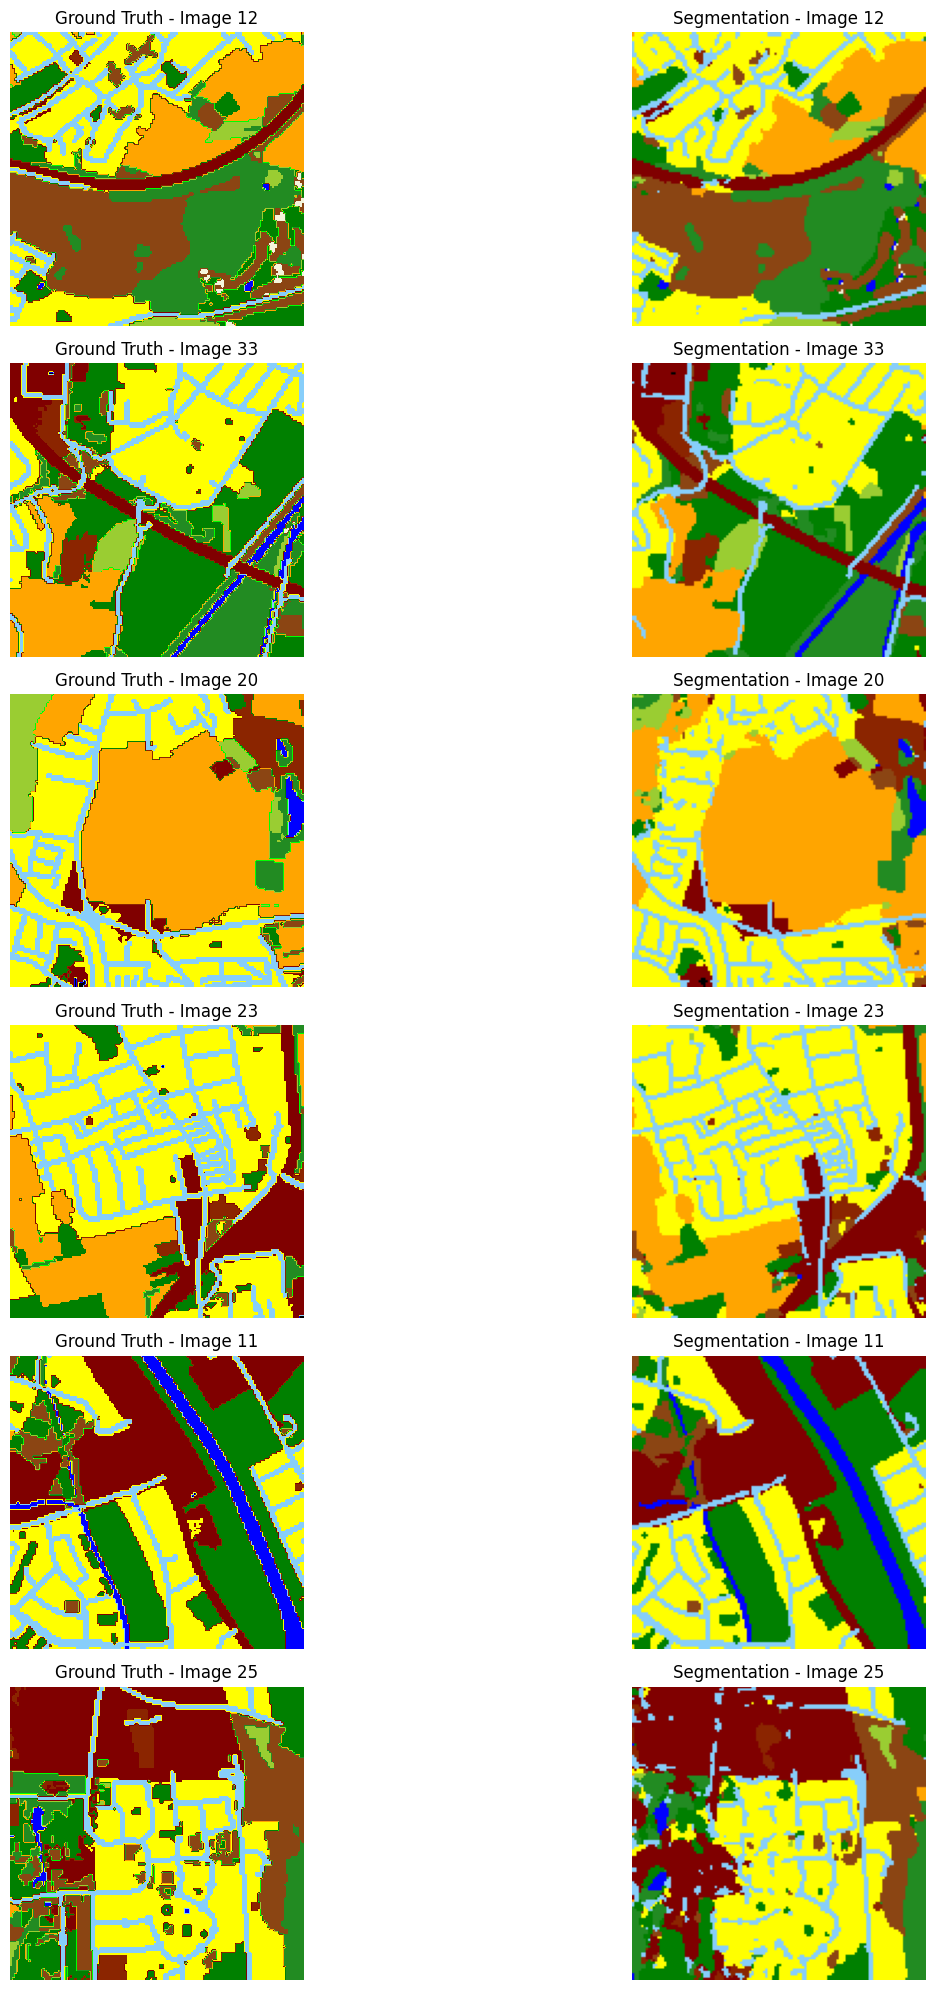

In [ ]:
from visualization import *
predict_random_and_show(model_unet_timm_resnest14d_ab, val_dataset_ab)

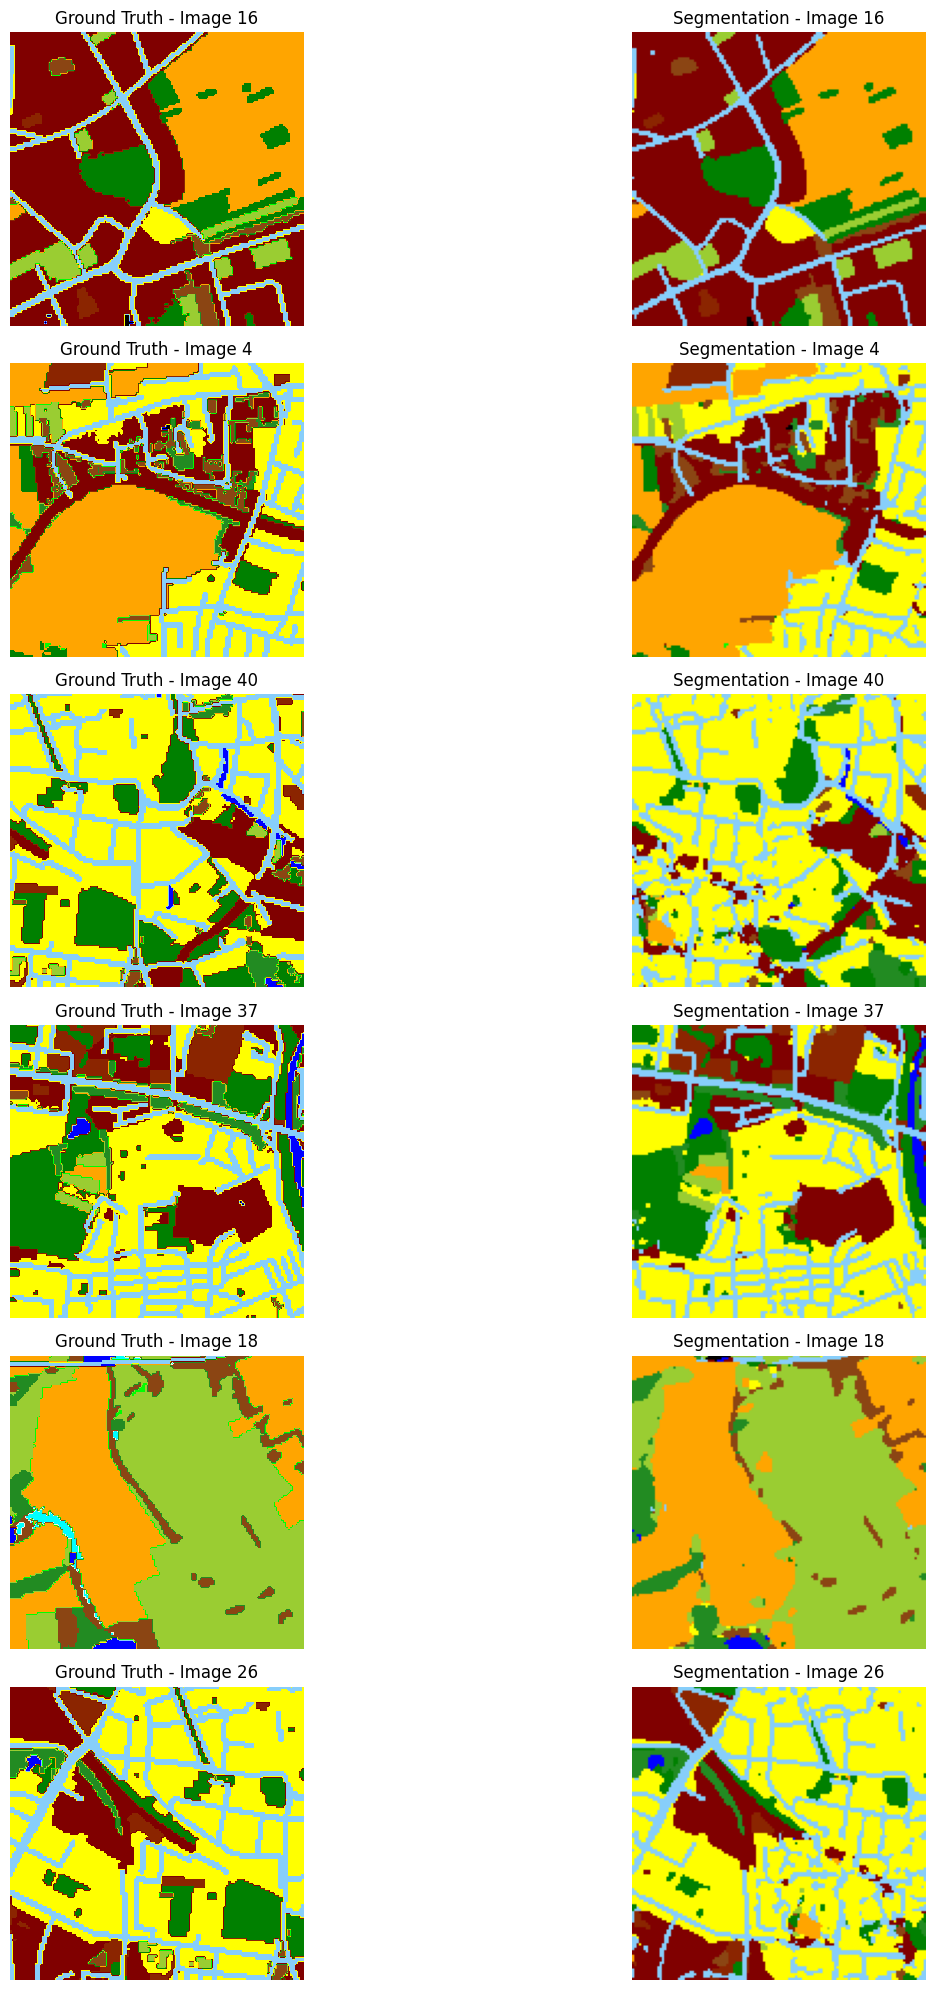

In [ ]:
from visualization import *
predict_random_and_show(model_unet_timm_resnest14d_ab, val_dataset_ab)

### BW Dataset

In [ ]:
from training import train

import segmentation_models_pytorch as smp

model_unet_timm_resnest14d_bw = smp.UnetPlusPlus(
    encoder_name="timm-resnest14d",        # encoder degistir
    encoder_weights="imagenet",
    in_channels=in_channels,
    classes=14,
)

loss_fn = nn.CrossEntropyLoss()

num_epochs=4
optimizer = optim.AdamW(model_unet_timm_resnest14d_bw.parameters(), lr=1e-4)
print("Learning Rate = 1e-4")
train(model_unet_timm_resnest14d_bw, training_dataloader_bw, val_dataloader_bw, loss_fn, optimizer, num_epochs)

print("Learning Rate = 1e-5")
num_epochs=4
optimizer = optim.AdamW(model_unet_timm_resnest14d_bw.parameters(), lr=1e-5)
train(model_unet_timm_resnest14d_bw, training_dataloader_bw, val_dataloader_bw, loss_fn, optimizer, num_epochs)

print("Learning Rate = 1e-6")
num_epochs=4
optimizer = optim.AdamW(model_unet_timm_resnest14d_bw.parameters(), lr=1e-6)
train(model_unet_timm_resnest14d_bw, training_dataloader_bw, val_dataloader_bw, loss_fn, optimizer, num_epochs)


Learning Rate = 1e-4
Epoch 1 | Val Loss:   0.9652 | Val Accuracy:   71.7654% | Val mIOU:   0.5827 | Val mF1:   0.7132 | Val Precision:   0.7089 | Val Recall:   0.7177
----- Epoch Time: 343.25s -----
Epoch 2 | Val Loss:   0.7305 | Val Accuracy:   78.6013% | Val mIOU:   0.6602 | Val mF1:   0.7761 | Val Precision:   0.7665 | Val Recall:   0.7860
----- Epoch Time: 344.96s -----
Epoch 3 | Val Loss:   0.5705 | Val Accuracy:   82.9004% | Val mIOU:   0.7189 | Val mF1:   0.8209 | Val Precision:   0.8130 | Val Recall:   0.8290
----- Epoch Time: 345.02s -----
Epoch 4 | Val Loss:   0.4811 | Val Accuracy:   85.4223% | Val mIOU:   0.7567 | Val mF1:   0.8498 | Val Precision:   0.8454 | Val Recall:   0.8542
----- Epoch Time: 345.64s -----
Learning Rate = 1e-5
Epoch 1 | Val Loss:   0.4014 | Val Accuracy:   87.8300% | Val mIOU:   0.7907 | Val mF1:   0.8728 | Val Precision:   0.8674 | Val Recall:   0.8783
----- Epoch Time: 345.34s -----
Epoch 2 | Val Loss:   0.3779 | Val Accuracy:   88.5244% | Val mIOU: 

In [ ]:
from training import validate

validate(model_unet_timm_resnest14d_bw, training_dataloader_bw, loss_fn)

(0.2660822161436081,
 91.56593495686849,
 tensor(0.8483, device='cuda:0'),
 tensor(0.9112, device='cuda:0'),
 tensor(0.9067, device='cuda:0'),
 tensor(0.9157, device='cuda:0'))

In [ ]:
from training import validate

validate(model_unet_timm_resnest14d_bw, val_dataloader_bw, loss_fn)

(0.33046661762159263,
 89.96074225094272,
 tensor(0.8232, device='cuda:0'),
 tensor(0.8949, device='cuda:0'),
 tensor(0.8902, device='cuda:0'),
 tensor(0.8996, device='cuda:0'))

In [ ]:
from training import validate

validate(model_unet_timm_resnest14d_bw, test_dataloader_bw, loss_fn)

(0.33054037659025903,
 89.95839365001426,
 tensor(0.8231, device='cuda:0'),
 tensor(0.8952, device='cuda:0'),
 tensor(0.8909, device='cuda:0'),
 tensor(0.8996, device='cuda:0'))

In [ ]:
#torch.save(model_unet_timm_resnest14d_bw, "Models/model_unet_timm_resnest14d_bw.pth")

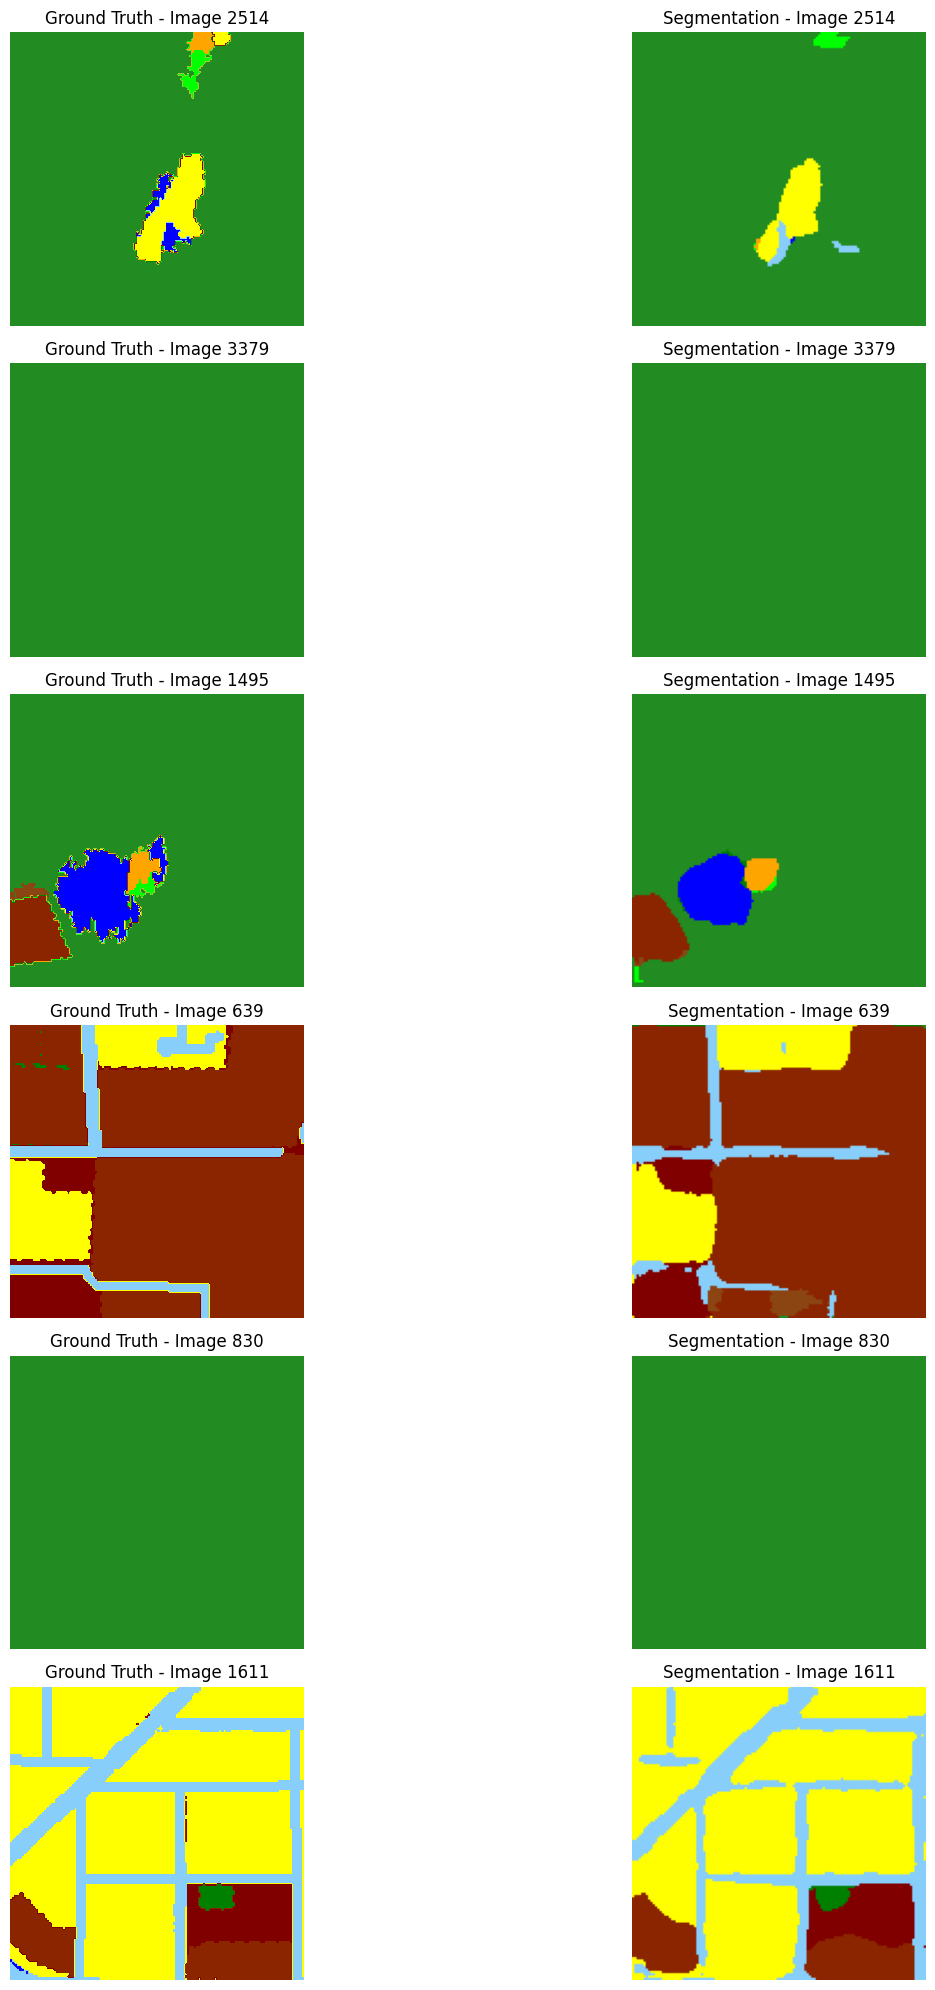

In [ ]:
from visualization import *
predict_random_and_show(best_model_bw, val_dataset_bw)

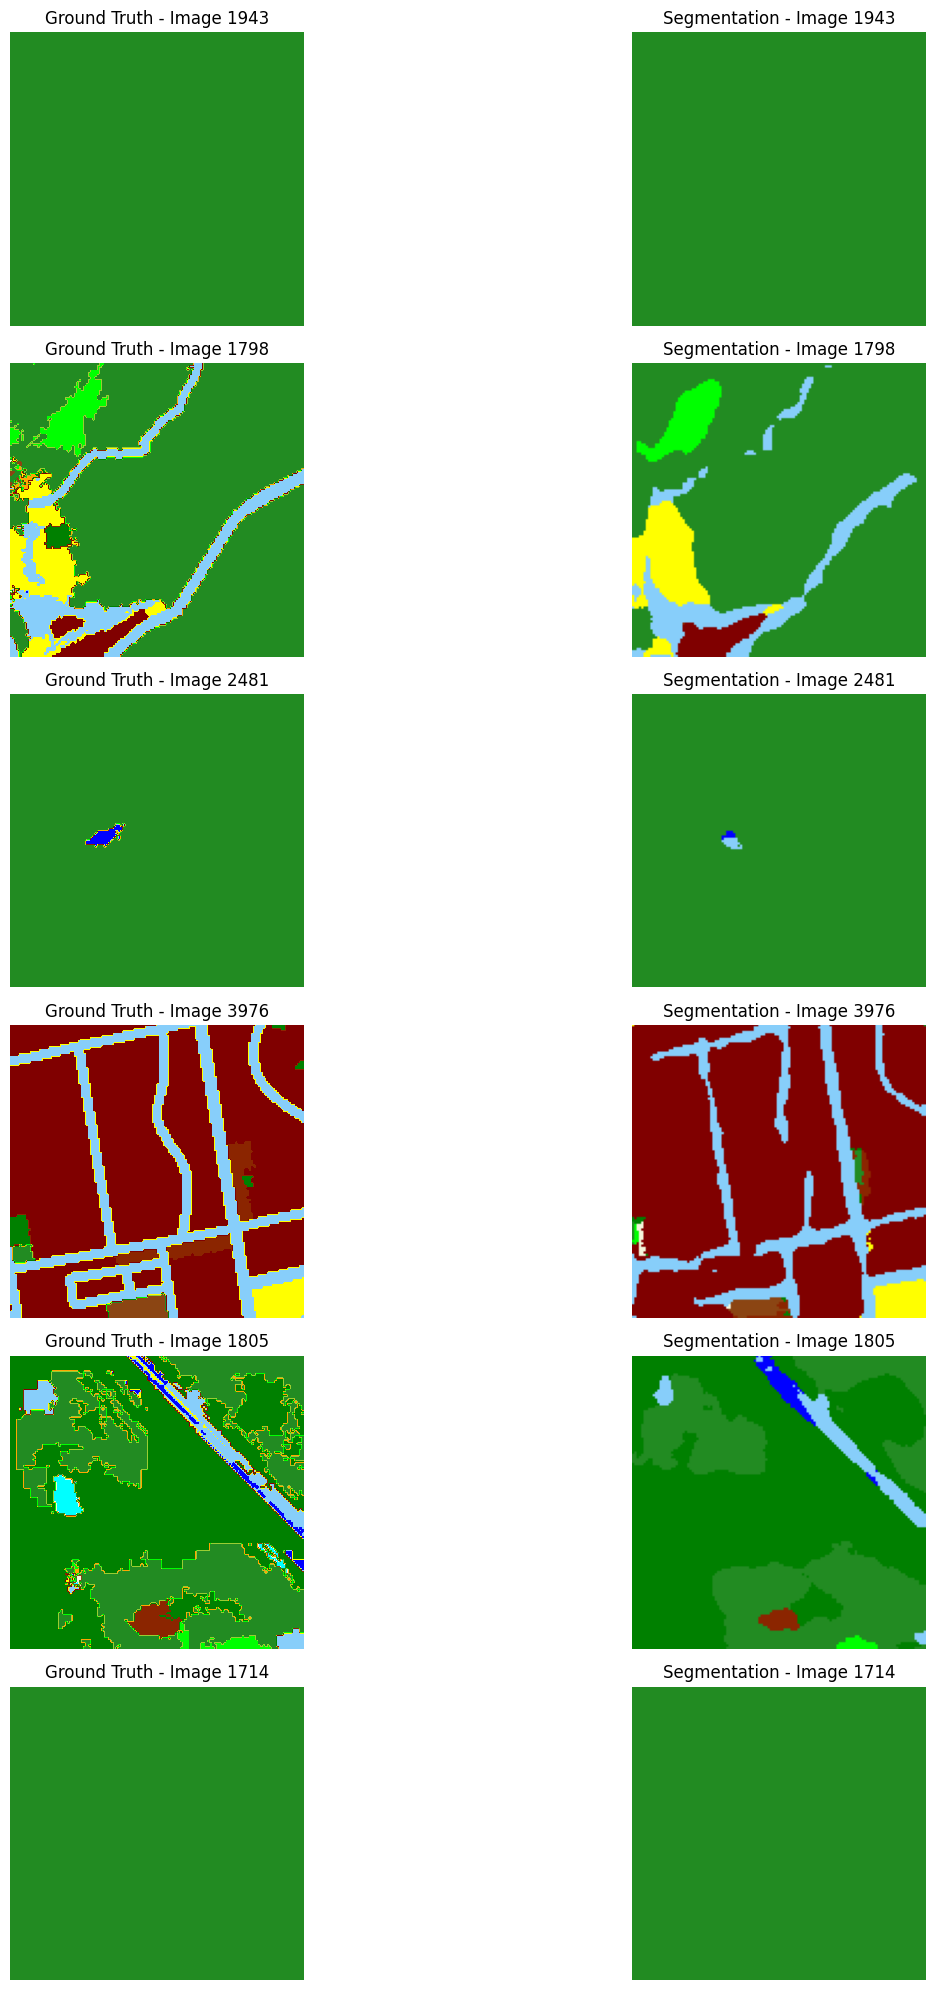

In [ ]:
from visualization import *
predict_random_and_show(best_model_bw, val_dataset_bw)